# Age, Gender, and Expression Recognition

## Notebook Imports

In [1]:
import os
import pathlib
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from typing import Tuple, Dict, List
from tqdm.autonotebook import tqdm
from timeit import default_timer as timer

import torch
from torch import nn
from torchinfo import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
torch.__version__

/tmp/ipykernel_17/3646614456.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'2.4.0+cpu'

## Data Loading & Data Preprocessing

In [2]:
IMAGE_PATH = Path("/kaggle/input/emotion-detection-fer")
TRAIN_PATH = IMAGE_PATH / "train"
TEST_PATH = IMAGE_PATH / "test"
IMAGE_PATH_LIST = list(IMAGE_PATH.glob('*/*/*.png'))

IMAGE_PATH, TRAIN_PATH, TEST_PATH, IMAGE_PATH_LIST[:5]

(PosixPath('/kaggle/input/emotion-detection-fer'),
 PosixPath('/kaggle/input/emotion-detection-fer/train'),
 PosixPath('/kaggle/input/emotion-detection-fer/test'),
 [PosixPath('/kaggle/input/emotion-detection-fer/test/fearful/im292.png'),
  PosixPath('/kaggle/input/emotion-detection-fer/test/fearful/im1022.png'),
  PosixPath('/kaggle/input/emotion-detection-fer/test/fearful/im633.png'),
  PosixPath('/kaggle/input/emotion-detection-fer/test/fearful/im934.png'),
  PosixPath('/kaggle/input/emotion-detection-fer/test/fearful/im927.png')])

In [3]:
def walk_through_dir(dir_path):
    "Walks through dir_path returning its contents"
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} in directories and {len(filenames)} in images in {dirpath}')

walk_through_dir(IMAGE_PATH)

There are 2 in directories and 0 in images in /kaggle/input/emotion-detection-fer
There are 7 in directories and 0 in images in /kaggle/input/emotion-detection-fer/test
There are 0 in directories and 1024 in images in /kaggle/input/emotion-detection-fer/test/fearful
There are 0 in directories and 111 in images in /kaggle/input/emotion-detection-fer/test/disgusted
There are 0 in directories and 958 in images in /kaggle/input/emotion-detection-fer/test/angry
There are 0 in directories and 1233 in images in /kaggle/input/emotion-detection-fer/test/neutral
There are 0 in directories and 1247 in images in /kaggle/input/emotion-detection-fer/test/sad
There are 0 in directories and 831 in images in /kaggle/input/emotion-detection-fer/test/surprised
There are 0 in directories and 1774 in images in /kaggle/input/emotion-detection-fer/test/happy
There are 7 in directories and 0 in images in /kaggle/input/emotion-detection-fer/train
There are 0 in directories and 4097 in images in /kaggle/input/e

## Data Transformation

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [5]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
    """Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version."""
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            # Original Image
            ax[0].imshow(f)
            ax[0].set_title(f'Original Image \nSize: {f.size}')
            ax[0].axis(False)

            # Transformed Image
            transformed_image = transform(f).permute(1, 2, 0) # (C, H, W) -> (H, W, C) for matplotlib
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed Image \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=14)

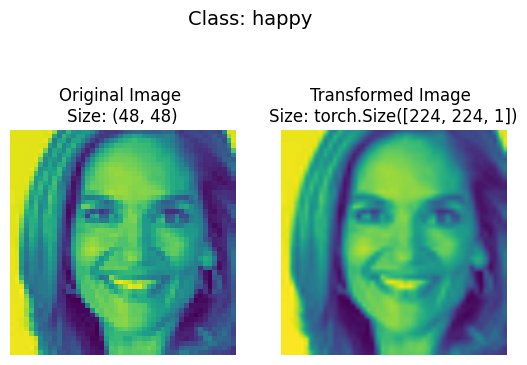

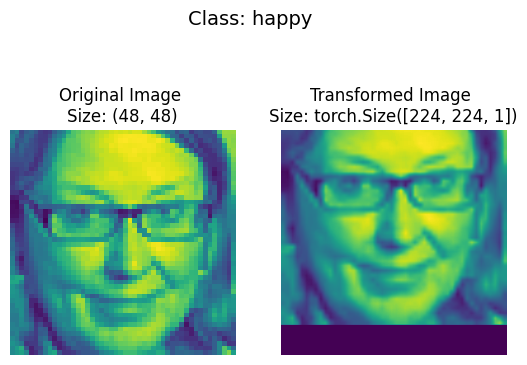

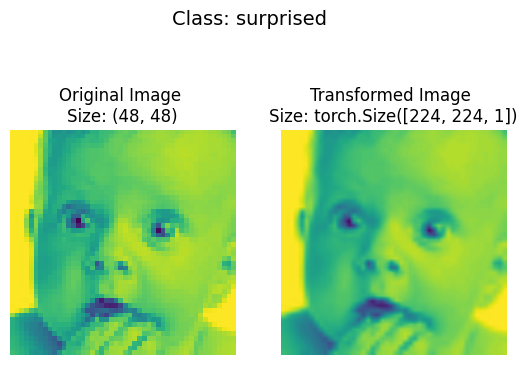

In [6]:
plot_transformed_images(image_paths=IMAGE_PATH_LIST,
                        transform=train_transform,
                        n=3,
                        seed=None)

In [7]:
train_data = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
test_data = datasets.ImageFolder(root=TEST_PATH, transform=test_transform)

In [8]:
train_data.classes, train_data.class_to_idx

(['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised'],
 {'angry': 0,
  'disgusted': 1,
  'fearful': 2,
  'happy': 3,
  'neutral': 4,
  'sad': 5,
  'surprised': 6})

In [9]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=NUM_WORKERS)

test_dataloader= DataLoader(dataset=test_data,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

In [10]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Model Training & Evaluation

## Edge Deployment & Testing

In [11]:
# age_gender_data = pd.read_csv("/kaggle/input/ageutk/ageutk_full.csv")
# age_bins = [i for i in range(0, 81, 5)]
# age_labels = [f"{age_bins[i]}-{age_bins[i+1]-1}" for i in range(len(age_bins)-1)]
# age_gender_data['age_category'] = pd.cut(age_gender_data['age'], bins=age_bins, labels=age_labels, right=False) 
# age_gender_data.head()